In [1]:
%matplotlib inline

import radical.analytics as ra
import radical.utils as ru
import radical.pilot as rp
import radical.entk as re
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
ra.version, re.version, rp.version, ru.version

('1.6.7', '1.6.7', '1.6.7', '1.6.7')

In [3]:
sdir = "./"
suds = ['re.session.login1.longhorn.tacc.utexas.edu.tg853783.018844.0000',
        're.session.login1.longhorn.tacc.utexas.edu.tg853783.018844.0001',
       're.session.login2.longhorn.tacc.utexas.edu.tg853783.018841.0002',
       #'re.session.login2.longhorn.tacc.utexas.edu.tg853783.018841.0003',
       're.session.login2.longhorn.tacc.utexas.edu.tg853783.018842.0000']

In [4]:
%%capture capt

ss = {}
for sid in suds:
    sp = sdir+sid
    ss[sid] = {'s': ra.Session(sp, 'radical.pilot')}
    ss[sid].update({'p': ss[sid]['s'].filter(etype='pilot'   , inplace=False),
                    't': ss[sid]['s'].filter(etype='task'    , inplace=False),
                    'u': ss[sid]['s'].filter(etype='unit'    , inplace=False),
                    'w': ss[sid]['s'].filter(etype='pipeline', inplace=False)})

In [5]:
EXEC_START_NAME = 'task_exec_start'
EXEC_STOP_NAME = 'task_exec_stop'
START_NAME = 'task_start'
STOP_NAME = 'task_stop'

In [6]:
for sid in ss:
    if 'resource_details' in ss[sid]['s'].get(etype='pilot')[0].cfg and ss[sid]['s'].get(etype='pilot')[0].cfg['resource_details'] is not None:
        cores_node = ss[sid]['s'].get(etype='pilot')[0].cfg['resource_details']['rm_info']['cores_per_node']
        gpus_node = ss[sid]['s'].get(etype='pilot')[0].cfg['resource_details']['rm_info']['gpus_per_node']
        smt = 1#ss[sid]['s'].get(etype='pilot')[0].cfg['resource_details']['rm_info']['smt']
    else:
        # TACC Longhorn
        cores_node = 42
        gpus_node = 4
        smt = 1
    ss[sid].update({'sid'       : ss[sid]['s'].uid,
                    'lm'        : ss[sid]['s'].get(etype='pilot')[0].cfg['agent_launch_method'],
                    'hostid'    : ss[sid]['s'].get(etype='pilot')[0].cfg['hostid'],
                    'cores_node': cores_node,
                    'gpus_node': gpus_node,
                    'smt': smt
    })
    ss[sid].update({
                    'pid'       : ss[sid]['p'].list('uid'),
                    'npilot'    : len(ss[sid]['p'].get()),
                    'npact'     : len(ss[sid]['p'].timestamps(state='PMGR_ACTIVE'))
    })
    ss[sid].update({
                    'ntask'     : len(ss[sid]['t'].get()),
                    'ntdone'    : len(ss[sid]['t'].timestamps(state='DONE')),
                    'ntfailed'  : len(ss[sid]['t'].timestamps(state='FAILED')),
                    'ntcanceled': len(ss[sid]['t'].timestamps(state='CANCLED'))
    })
    ss[sid].update({'pres'      : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['resource'],
                    'ncores'    : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['cores'],
                    'ngpus'     : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['gpus']
    })
    ss[sid].update({'nnodes'    : int(ss[sid]['ncores']/ss[sid]['cores_node'])})

In [7]:
info = []
for sid in suds:
    info.append({'session'   : sid,
                 'resource'  : ss[sid]['pres'],
                 'cores_node': ss[sid]['cores_node'],
                 'gpus_node' : ss[sid]['gpus_node'],
                 'pilot_lm'  : ss[sid]['lm'], 
                 'pilots'    : ss[sid]['npilot'],
                 'ps_active' : ss[sid]['npact'],
                 'cores'     : int(ss[sid]['ncores']/ss[sid]['smt']), 
                 'gpus'      : ss[sid]['ngpus'], 
                 'nodes'     : ss[sid]['nnodes'], 
                 'tasks'     : ss[sid]['ntask'], 
                 't_done'   : ss[sid]['ntdone'],  
                 't_failed' : ss[sid]['ntfailed']})

df_info = pd.DataFrame(info) 
df_info

,session,resource,cores_node,gpus_node,pilot_lm,pilots,ps_active,cores,gpus,nodes,tasks,t_done,t_failed
0,re.session.login1.longhorn.tacc.utexas.edu.tg8...,tacc.longhorn,40,4,SRUN,1,1,120,12,3,30,30,0
1,re.session.login1.longhorn.tacc.utexas.edu.tg8...,tacc.longhorn,40,4,SRUN,1,1,1200,120,30,246,135,111
2,re.session.login2.longhorn.tacc.utexas.edu.tg8...,tacc.longhorn,40,4,SRUN,1,1,120,12,3,30,30,0
3,re.session.login2.longhorn.tacc.utexas.edu.tg8...,tacc.longhorn,40,4,SRUN,1,1,120,12,3,30,30,0


In [8]:
for sid in ss:
    w  = ss[sid]['w']
    t  = ss[sid]['t']
    u = ss[sid]['u']
    p  = ss[sid]['p']
    p0 = p.get(uid=ss[sid]['pid'])[0]

    ttx_p = p0.duration(event=rp.utils.PILOT_DURATIONS_DEBUG['p_agent_runtime'])
    ttx_u = ttx_u = t.duration( event=[ {ru.EVENT: EXEC_START_NAME, ru.STATE: None                  },      
                                   {ru.EVENT: EXEC_STOP_NAME , ru.STATE: None                  } ])

    ss[sid].update({
      'ttc'  : p0.duration(event=[ {ru.EVENT: 'state'        , ru.STATE: rp.NEW                }, 
                                  [{ru.EVENT: 'state'        , ru.STATE: rp.DONE               },
                                   {ru.EVENT: 'state'        , ru.STATE: rp.CANCELED           },
                                   {ru.EVENT: 'state'        , ru.STATE: rp.FAILED             }]]),
      'ttq_p': p0.duration(event=[ {ru.EVENT: 'state'        , ru.STATE: rp.PMGR_ACTIVE_PENDING}, 
                                   {ru.EVENT: 'state'        , ru.STATE: rp.PMGR_ACTIVE        } ]),
      'ttx_w': w.duration( event=[ {ru.EVENT: 'state'        , ru.STATE: re.states.SCHEDULING  },
                                   {ru.EVENT: 'state'        , ru.STATE: re.states.DONE        } ]),
      'ttx_u': ttx_u,
      'ttx_p': ttx_p,
      'sub_t': t.duration( event=[ {ru.EVENT: 'state'        , ru.STATE: re.states.SCHEDULING  },
                                   {ru.EVENT: 'state'        , ru.STATE: re.states.SUBMITTING  } ]),
      'ttx_t': t.duration( event=[ {ru.EVENT: 'state'        , ru.STATE: re.states.SUBMITTING  },
                                  [{ru.EVENT: 'state'        , ru.STATE: re.states.COMPLETED   },
                                   {ru.EVENT: 'state'        , ru.STATE: re.states.CANCELED    },
                                   {ru.EVENT: 'state'        , ru.STATE: re.states.FAILED      }]]),
    })
    
    ss[sid].update({'ovh_rct': ss[sid]['ttx_p'] - ss[sid]['ttx_u']})

In [9]:
df = pd.DataFrame.from_dict(ss, orient='index')
df

,s,p,t,u,w,sid,lm,hostid,cores_node,gpus_node,...,ngpus,nnodes,ttc,ttq_p,ttx_w,ttx_u,ttx_p,sub_t,ttx_t,ovh_rct
re.session.login1.longhorn.tacc.utexas.edu.tg853783.018844.0000,<radical.analytics.session.Session object at 0...,<radical.analytics.session.Session object at 0...,<radical.analytics.session.Session object at 0...,<radical.analytics.session.Session object at 0...,<radical.analytics.session.Session object at 0...,re.session.login1.longhorn.tacc.utexas.edu.tg8...,SRUN,c003-011.longhorn.tacc.utexas.edu,40,4,...,12,3,10773.568017,63.646582,10654.788482,10593.0,10759.0,7.841939,10637.510175,166.0
re.session.login1.longhorn.tacc.utexas.edu.tg853783.018844.0001,<radical.analytics.session.Session object at 0...,<radical.analytics.session.Session object at 0...,<radical.analytics.session.Session object at 0...,<radical.analytics.session.Session object at 0...,<radical.analytics.session.Session object at 0...,re.session.login1.longhorn.tacc.utexas.edu.tg8...,SRUN,c005-003.longhorn.tacc.utexas.edu,40,4,...,120,30,19008.506574,10521.406605,8451.998443,8388.0,8525.0,6.784428,8430.412041,137.0
re.session.login2.longhorn.tacc.utexas.edu.tg853783.018841.0002,<radical.analytics.session.Session object at 0...,<radical.analytics.session.Session object at 0...,<radical.analytics.session.Session object at 0...,<radical.analytics.session.Session object at 0...,<radical.analytics.session.Session object at 0...,re.session.login2.longhorn.tacc.utexas.edu.tg8...,SRUN,c002-003.longhorn.tacc.utexas.edu,40,4,...,12,3,10960.866464,69.118805,10853.869354,10793.0,10949.0,17.779855,10826.286978,156.0
re.session.login2.longhorn.tacc.utexas.edu.tg853783.018842.0000,<radical.analytics.session.Session object at 0...,<radical.analytics.session.Session object at 0...,<radical.analytics.session.Session object at 0...,<radical.analytics.session.Session object at 0...,<radical.analytics.session.Session object at 0...,re.session.login2.longhorn.tacc.utexas.edu.tg8...,SRUN,c003-009.longhorn.tacc.utexas.edu,40,4,...,12,3,10987.780521,67.860235,10897.005376,10831.0,10976.0,17.991137,10868.316483,145.0


In [10]:
g = df.groupby(by='nnodes')
means = g.mean()
errors = g.std()

<AxesSubplot:xlabel='nnodes'>

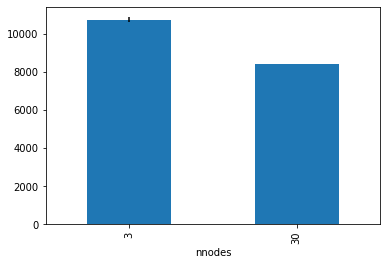

In [11]:
fig, ax = plt.subplots()
means['ttx_u'].plot.bar(yerr=errors, ax=ax)

<AxesSubplot:xlabel='nnodes'>

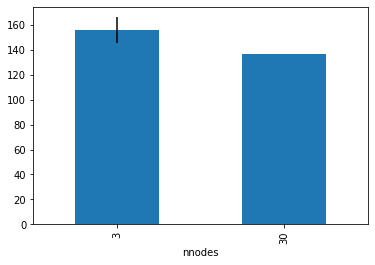

In [12]:
fig, ax = plt.subplots()
means['ovh_rct'].plot.bar(yerr=errors, ax=ax)

In [13]:
for v in df.iloc:
     print(v['sid'], v['ttx_p'] - v['ttx_u'], v['ttx_u'], v['nnodes'])

re.session.login1.longhorn.tacc.utexas.edu.tg853783.018844.0000 166.0 10593.0 3
re.session.login1.longhorn.tacc.utexas.edu.tg853783.018844.0001 137.0 8388.0 30
re.session.login2.longhorn.tacc.utexas.edu.tg853783.018841.0002 156.0 10793.0 3
re.session.login2.longhorn.tacc.utexas.edu.tg853783.018842.0000 145.0 10831.0 3


In [14]:
%matplotlib inline
%run 'bin/notebook_utils.py'
%run 'bin/plot_utilization.py'
import matplotlib.ticker as mticker
from matplotlib.ticker import MaxNLocator
#plt.style.use(ra.get_mplstyle('radical_mpl'))
#plt.style.use('seaborn-ticks')

<Figure size 432x288 with 0 Axes>

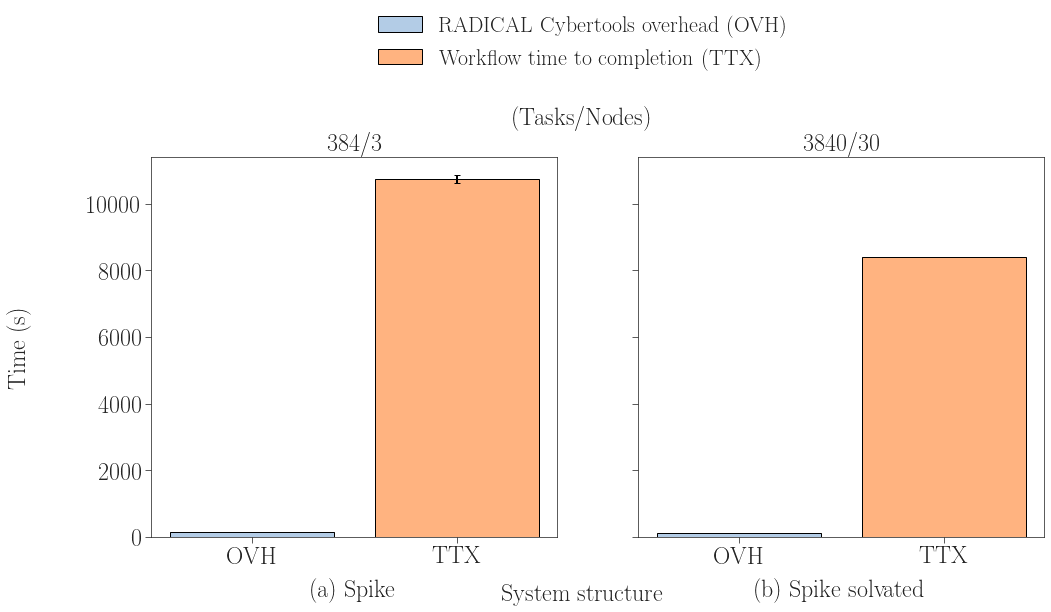

In [16]:
fwidth, fhight = 16,7
#fwidth, fhight = ra.get_plotsize(995)
fig, axarr = plt.subplots(1, len(means), sharey=True, figsize=(fwidth, fhight))

i = 0
j = 'a'
for row in means.iloc:

    ntask = row.name * 8 * 16
    nnodes = row.name
    ax = axarr[i]
    if i == 0:
        ax.set_xlabel('(%s) Spike' % j, labelpad=10)
    else:
        ax.set_xlabel('(%s) Spike solvated' % j, labelpad=10)
        
    ax.title.set_text('%s/%s' % (ntask, nnodes))


    keyname =  "{}/{}".format(ntask, nnodes)
    ax.bar(x = 'OVH', height = means.iloc[i]['ovh_rct'], yerr = errors.iloc[i]['ovh_rct'], color = tableau20[1])
    ax.bar(x = 'TTX', height = means.iloc[i]['ttx_u'], yerr = errors.iloc[i]['ttx_u'], color = tableau20[3])

    i = i+1
    j = chr(ord(j) + 1)
fig.suptitle("(Tasks/Nodes)")
fig.text(  0,  0.5, 'Time (s)', va='center', rotation='vertical')
fig.text(  0.5,0, 'System structure'  , ha='center')
fig.legend(['RADICAL Cybertools overhead (OVH)', 'Workflow time to completion (TTX)'], loc='upper center', 
           bbox_to_anchor=(0.5, 1.2), ncol=1)
    
plt.savefig('figures/westpa_longhorn_2021_ovh_ttx.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/westpa_longhorn_2021_ovh_ttx.png', dpi=300, bbox_inches='tight')

In [18]:
means

,cores_node,gpus_node,smt,npilot,npact,ntask,ntdone,ntfailed,ntcanceled,ncores,ngpus,ttc,ttq_p,ttx_w,ttx_u,ttx_p,sub_t,ttx_t,ovh_rct
nnodes,,,,,,,,,,,,,,,,,,,
3,40,4,1,1,1,30,30,0,0,120,12,10907.405001,66.875207,10801.887737,10739.0,10894.666667,14.537644,10777.371212,155.666667
30,40,4,1,1,1,246,135,111,0,1200,120,19008.506574,10521.406605,8451.998443,8388.0,8525.000000,6.784428,8430.412041,137.000000


In [19]:
errors

,cores_node,gpus_node,smt,npilot,npact,ntask,ntdone,ntfailed,ntcanceled,ncores,ngpus,ttc,ttq_p,ttx_w,ttx_u,ttx_p,sub_t,ttx_t,ovh_rct
nnodes,,,,,,,,,,,,,,,,,,,
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,116.684811,2.86601,129.204575,127.859298,118.263829,5.799612,122.932714,10.503968
30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
